In [1]:
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import string
from gensim.models.phrases import Phrases, Phraser
import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import lemmatize
from pprint import pprint
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings


%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
stop_words = stopwords.words('english')
nlp = spacy.load('en', disable=['parser', 'ner'])

In [3]:
cnn = pd.read_csv("../data/cnn.csv")

In [4]:
cnn_abstract = cnn[['Abstract','Title']].dropna().reset_index(drop = True)

In [5]:
cnn_abstract.isnull().sum()

Abstract    0
Title       0
dtype: int64

In [6]:
# clean the text using below for loop
clean_text = []
for index in range(len(cnn_abstract)):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', cnn_abstract['Abstract'][index])

    #Convert to lowercase
    text = text.lower()
    
    #remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    #Convert to list of words from text
    text = text.split()
    
    # remove stop words after splitting text and joint the words
    text =[word for word in text if word not in stop_words]
    text = " ".join(text)
    # lemmatize words using spacy
    
    doc = nlp(text)
    text=" ".join([token.lemma_ for token in doc])

   # append to clean_text
    clean_text.append(text)
    
cnn_abstract['clean_text'] = clean_text

In [7]:
cnn_abstract.head()

,Abstract,Title,clean_text
0,Incomplete surgical resection of head and neck...,The Use of Optical Coherence Tomography and Co...,incomplete surgical resection head neck squamo...
1,We implement 2 different multitask learning (M...,Automatic extraction of cancer registry report...,implement different multitask learn mtl techni...
2,Convolutional neural network (CNN) is employed...,Convolutional neural networks for the design a...,convolutional neural network cnn employ constr...
3,The purpose of the present study was to evalua...,Deep Learning-Based Deep Brain Stimulation Tar...,purpose present study evaluate deep learning b...
4,We apply convolutional neural network (CNN) mo...,Estimating PM2.5 concentration of the contermi...,apply convolutional neural network cnn model e...


In [8]:
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [9]:
#data_words_nostops = remove_stopwords(data_words)

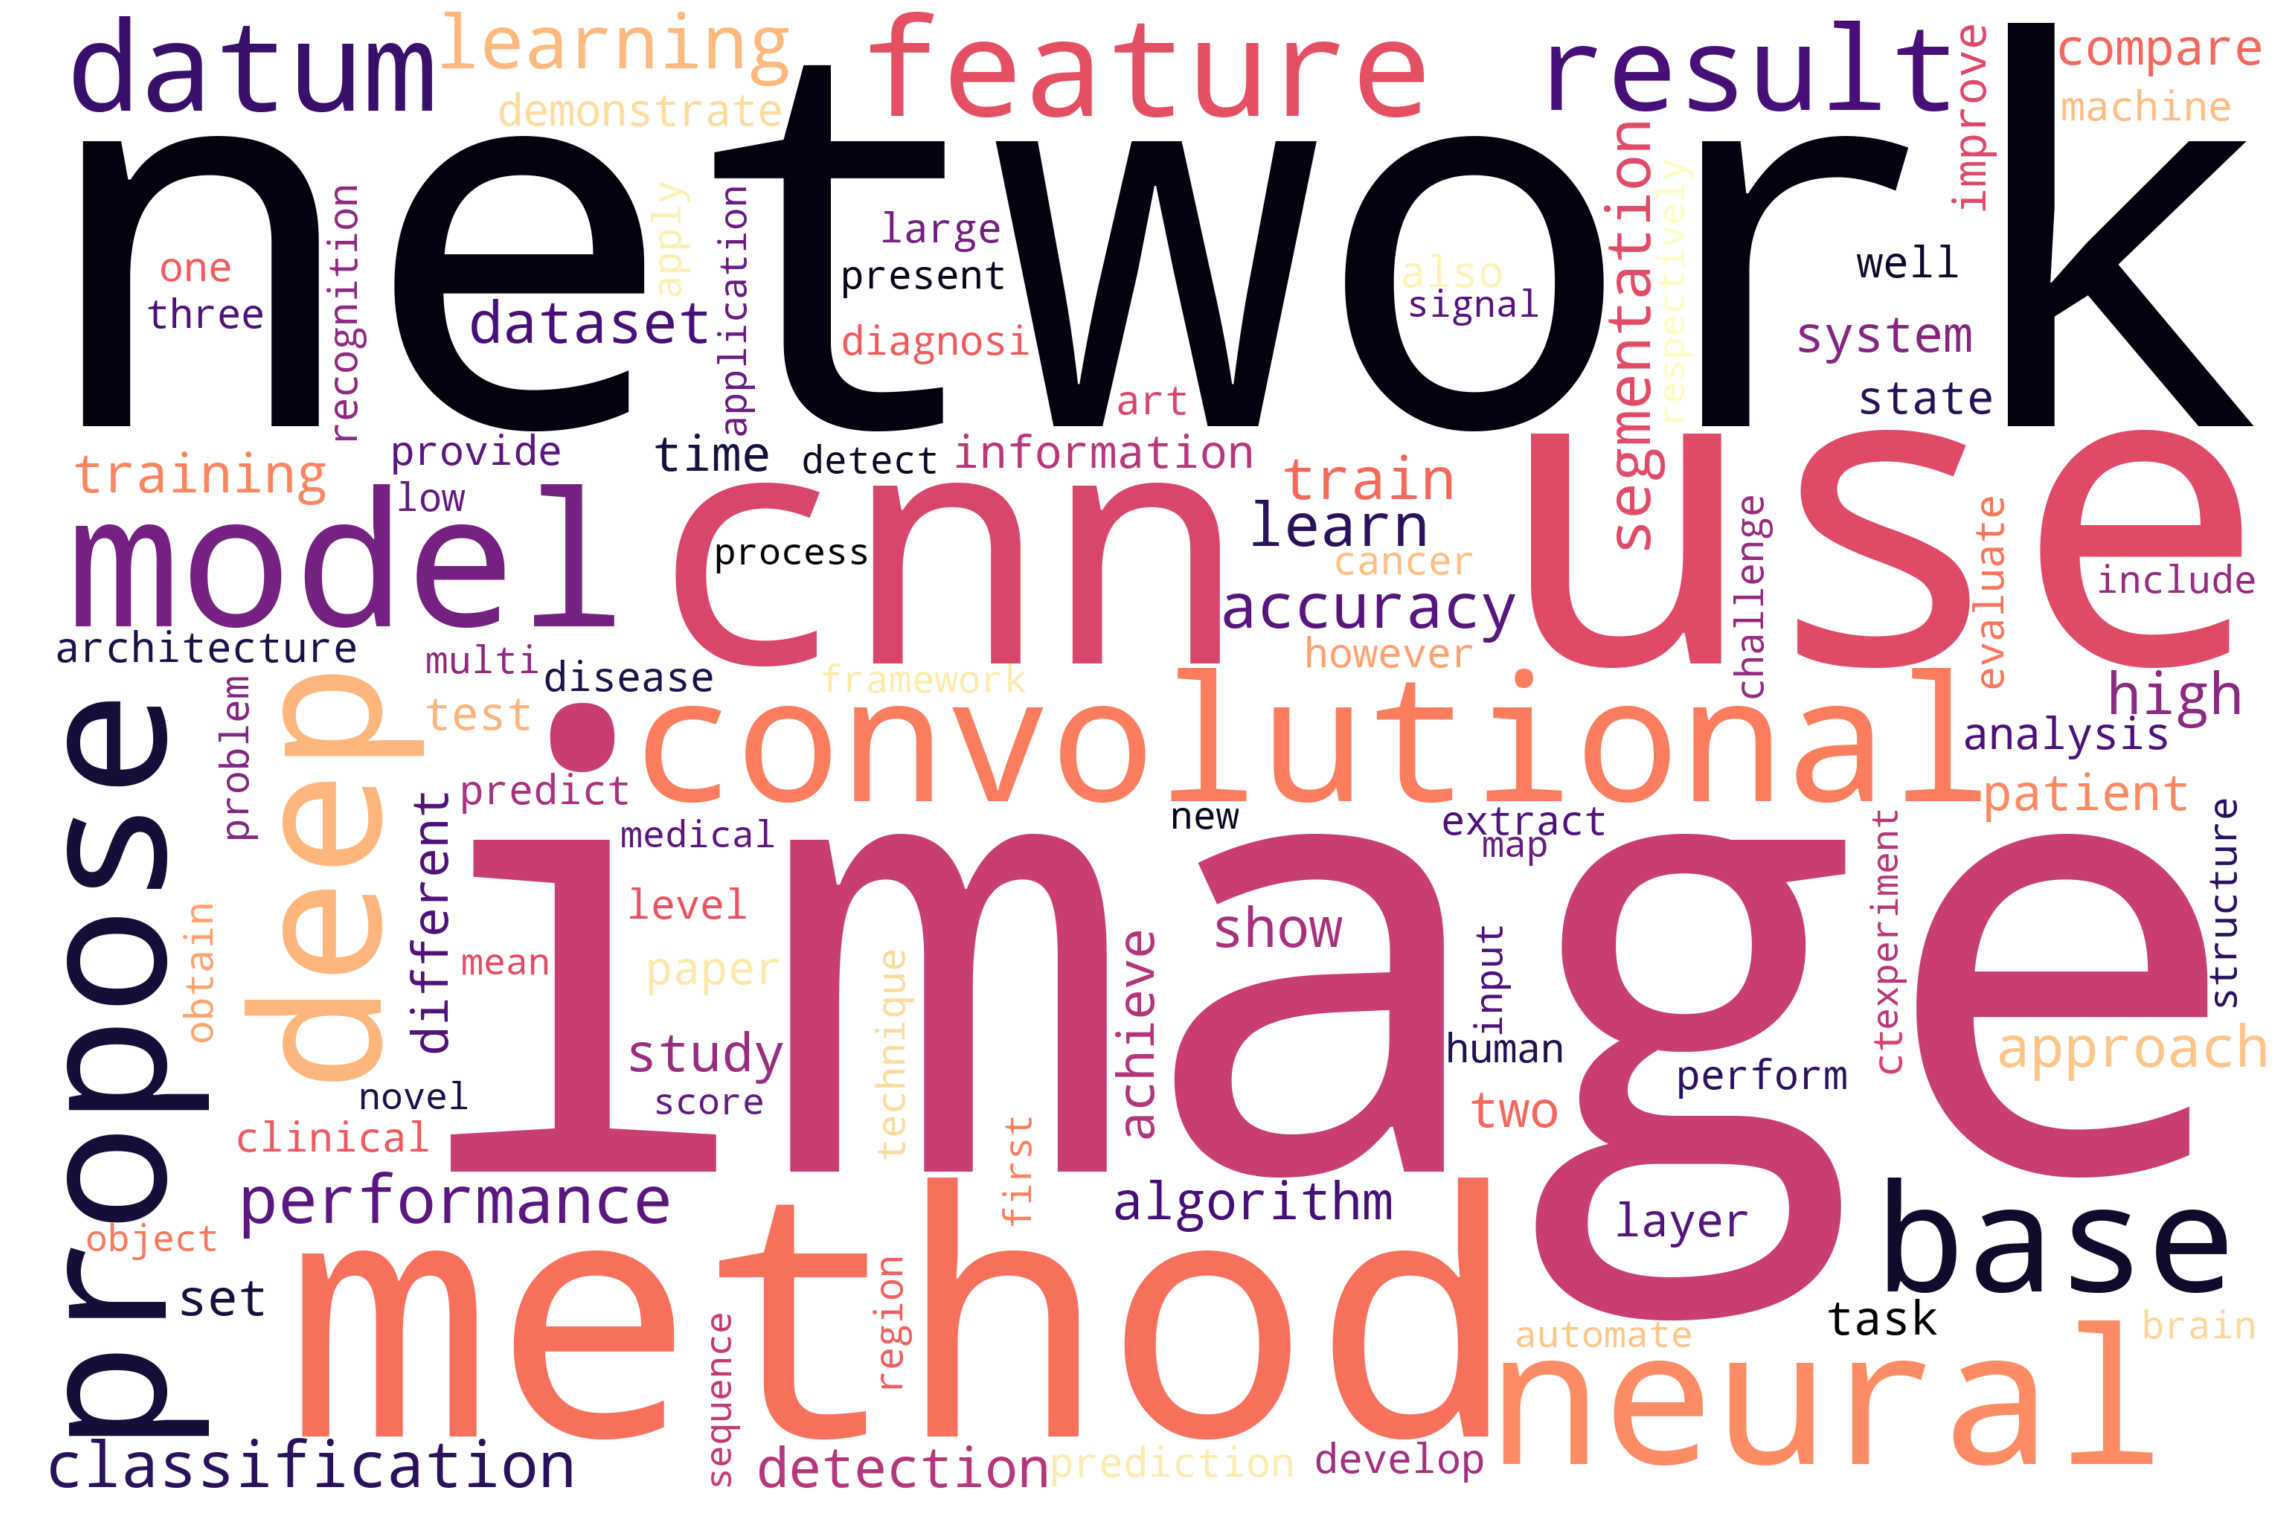

In [10]:
#Word cloud of 100 words in the entire clean text
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white',colormap=plt.cm.magma,
                          stopwords=stop_words,
                          max_words=100,
                           
                          random_state=42,collocations=False
                         ).generate(str(clean_text))

#print(wordcloud)
plt.figure(figsize = (40, 30), edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("word2.png")
plt.show()


                  Bigram        Freq
0                  image  175.700668
1                    cnn  121.831113
2                 method  121.661471
3                    use  121.228987
4                  model  115.306602
5                network  113.735264
6                feature  103.285466
7                propose   99.355931
8                   deep   94.335387
9                   base   88.168453
10          segmentation   86.484172
11                 datum   84.214173
12        classification   79.949730
13                neural   78.180411
14        neural network   75.681183
15              learning   73.501256
16         convolutional   68.609602
17             detection   67.019898
18                result   66.520693
19                 learn   66.483986
20           performance   66.112566
21              accuracy   65.719993
22               dataset   64.825688
23              approach   64.009954
24         deep learning   60.511456
25             algorithm   60.404609
2

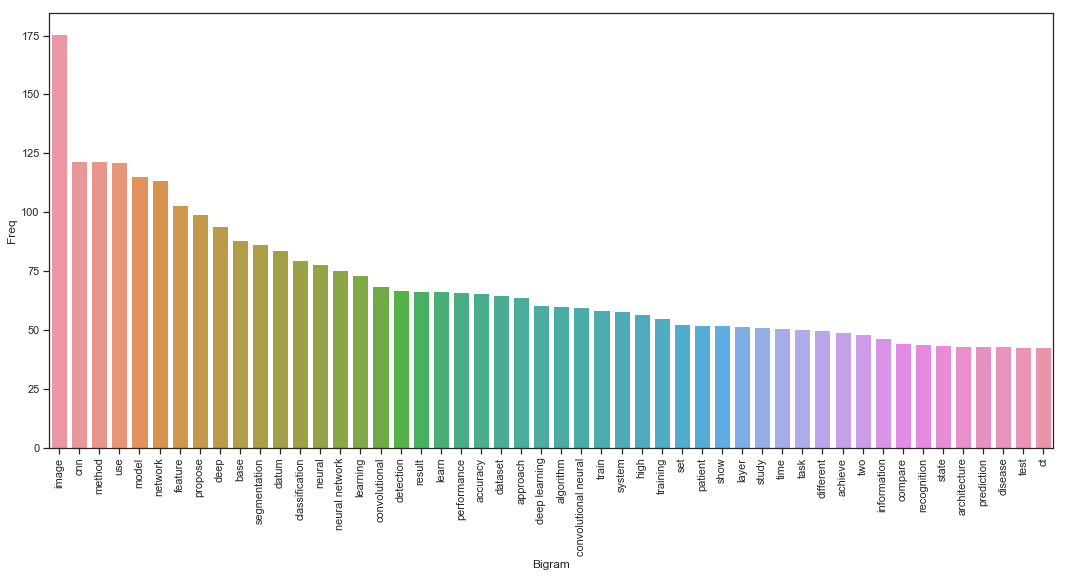

In [11]:
#Most frequently occuring bigrams in the data. plot both bar plot and word cloud of bigrams in the data 
def top_bi_grams(clean_text, n=None):
    
    vectorizer = TfidfVectorizer(ngram_range = (1,2), min_df = 5).fit(clean_text)
    bows = vectorizer.transform(clean_text)
    sumwords = bows.sum(axis=0) 
    words_freq = [(word, sumwords[0, idx]) for word, idx in     
                  vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top_bigrams = top_bi_grams(clean_text, n=50)
top_bigrams_df = pd.DataFrame(top_bigrams)
top_bigrams_df.columns=["Bigram", "Freq"]
print(top_bigrams_df)

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(18,8)}, style ='white' )
sns.set_style("ticks")

h=sns.barplot(x="Bigram", y="Freq", data=top_bigrams_df)
h.set_xticklabels(h.get_xticklabels(), rotation=90);

In [12]:
top_bigrams_df.Bigram.tolist()

['image',
 'cnn',
 'method',
 'use',
 'model',
 'network',
 'feature',
 'propose',
 'deep',
 'base',
 'segmentation',
 'datum',
 'classification',
 'neural',
 'neural network',
 'learning',
 'convolutional',
 'detection',
 'result',
 'learn',
 'performance',
 'accuracy',
 'dataset',
 'approach',
 'deep learning',
 'algorithm',
 'convolutional neural',
 'train',
 'system',
 'high',
 'training',
 'set',
 'patient',
 'show',
 'layer',
 'study',
 'time',
 'task',
 'different',
 'achieve',
 'two',
 'information',
 'compare',
 'recognition',
 'state',
 'architecture',
 'prediction',
 'disease',
 'test',
 'ct']

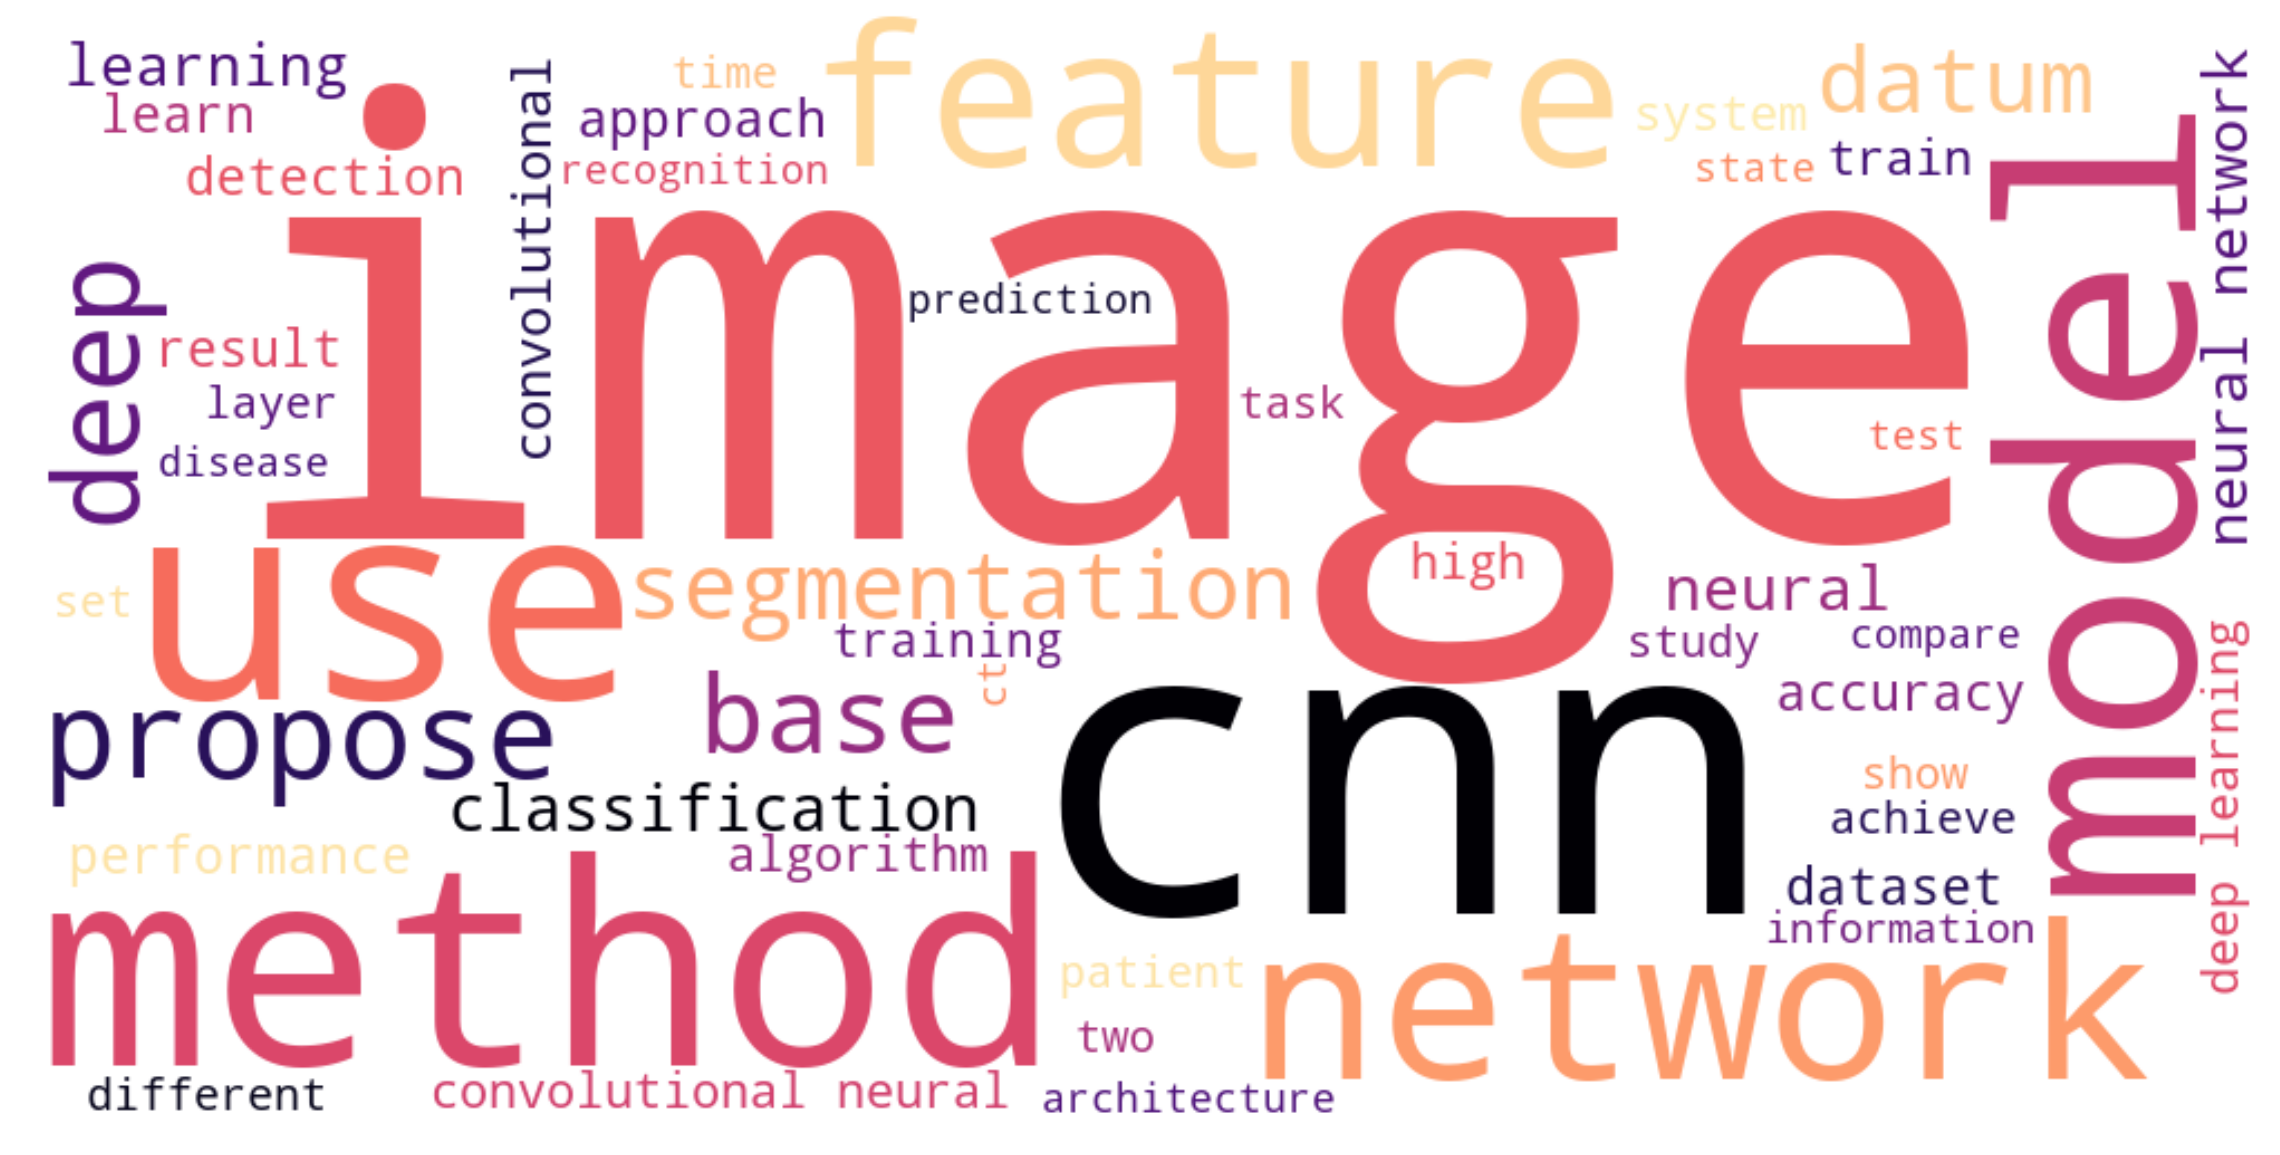

In [13]:
bigrams = {}
for w, x in top_bigrams_df.values:
    bigrams[w] = x
wordcloud = WordCloud(width = 1000,
    height = 500,background_color='white',colormap=plt.cm.magma,margin=5,
                     min_word_length =2, relative_scaling=1, collocations=False)
wordcloud.generate_from_frequencies(bigrams)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [32]:
def textprocess(text):
    for sentence in text:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
words = list(textprocess(clean_text))
print(words[:1])

[['incomplete', 'surgical', 'resection', 'head', 'neck', 'squamous', 'cell', 'carcinoma', 'hnscc', 'common', 'cause', 'local', 'hnscc', 'recurrence', 'currently', 'surgeon', 'rely', 'pre', 'operative', 'image', 'direct', 'visualization', 'palpation', 'freeze', 'section', 'determine', 'extent', 'tissue', 'resection', 'demonstrate', 'optical', 'coherence', 'tomography', 'oct', 'minimally', 'invasive', 'non', 'ionizing', 'near', 'infrared', 'mesoscopic', 'image', 'modality', 'resolve', 'subsurface', 'difference', 'normal', 'abnormal', 'head', 'neck', 'mucosa', 'previous', 'work', 'utilize', 'oct', 'image', 'limited', 'evaluation', 'small', 'region', 'interest', 'generate', 'frame', 'frame', 'oct', 'technology', 'capable', 'perform', 'rapid', 'volumetric', 'imaging', 'capacity', 'expertise', 'analyze', 'massive', 'amount', 'image', 'datum', 'lack', 'study', 'evaluate', 'ability', 'train', 'convolutional', 'neural', 'network', 'cnn', 'classify', 'oct', 'image', 'head', 'neck', 'mucosa', 'di

In [15]:
stop_words = stopwords.words('english')
len(stop_words)

179

In [16]:
#extend_stopwords = 

In [17]:
# p=Counter(extend_stopwords)
# x=pd.Series(p)
# x

In [18]:
stop_words = stopwords.words('english')
print(len(stop_words))
stop_words.extend(['overall', 'perform' , 'model','use', 
                   'lr','ext','respective','respectively', 'accuracy', 'relatively','small','challenge','validation',
                  'show','cnn','li', 'small','show','development','training','transfer','twos','cnns','pre','auroc','two','method',
                   'segmentation','convolutional', 'neural', 'network', 'show','task','compare','state','study', 'retrospective', 'datum',
                   'collect', 'institutional', 'review', 'board', 'approve', 'study','base', 'approach', 'high', 'auc', 'fall', 
                   'currently', 'important', 'specifically', 'fall', 'detection', 'call', 'fall', 'detection', 'dataset', 'study', 'approach', 'fall', 
                   'require', 'focus', 'base', 'approach', 'paper', 'present', 'fall', 'due', 'recent', 'exponential', 'increase',
                  'specificity','basis', 'function', 'kernel', 'area', 'curve', 'auc', 'may', 'useful','explore', 'two', 'different',
                   'deep', 'learning', 'approach','require','may', 'useful','information', 'basis','obtain',
                   'al', 'research', 'grid', 'search', 'fold', 'cross'])
print(len(stop_words))

179
278


In [19]:
no_stop_words=[[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in words]

In [20]:
bigram = Phrases(words, min_count=2, threshold=100)
trigram = Phrases(words, min_count=2, threshold=100)
bigrams_mod = Phraser(bigram)
trigrams_mod = Phraser(trigram)

In [21]:
def bigrams(texts):
    return [bigrams_mod[doc] for doc in texts]
words_bigrams = bigrams(no_stop_words)

def trigrams(texts):
    return [trigrams_mod[doc] for doc in texts]
words_trigrams = trigrams(no_stop_words)

In [22]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
data_lemmatized = lemmatization(words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [24]:
# Create Dictionary
id2word = corpora.Dictionary(words_bigrams)

# Create Corpus
texts = words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 3), (25, 2), (26, 5), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 2), (42, 3), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1)]]


In [25]:
id2word[12]

'demonstrate'

In [26]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

In [27]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.072*"detail" + 0.065*"vs" + 0.039*"version" + 0.038*"accelerometer" + '
  '0.035*"internal" + 0.030*"external" + 0.028*"thyroid_nodule" + '
  '0.027*"split" + 0.016*"fcnn" + 0.006*"website"'),
 (1,
  '0.064*"tissue" + 0.059*"cancer" + 0.052*"early" + 0.035*"breast_cancer" + '
  '0.030*"polyp" + 0.029*"breast" + 0.023*"stain" + 0.022*"pretraine" + '
  '0.020*"pathologist" + 0.018*"histopathology"'),
 (2,
  '0.083*"nodule" + 0.081*"lung" + 0.066*"ecg" + 0.050*"dose" + 0.050*"noise" '
  '+ 0.041*"handle" + 0.033*"lstm" + 0.030*"denoise" + 0.028*"long_short" + '
  '0.028*"term_memory"'),
 (3,
  '0.120*"eeg" + 0.056*"registration" + 0.039*"seizure" + 0.038*"ml" + '
  '0.031*"signal" + 0.027*"inter" + 0.025*"skin" + 0.020*"hospital" + '
  '0.016*"muscle" + 0.015*"spine"'),
 (4,
  '0.137*"dcnn" + 0.065*"mass" + 0.057*"ci" + 0.049*"receiver_operate" + '
  '0.021*"benign" + 0.021*"screen" + 0.020*"lv" + 0.020*"diabetic_retinopathy" '
  '+ 0.019*"dbt" + 0.018*"sign"'),
 (5,
  '0.084*"r

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.099881799069351

Coherence Score:  0.4020577573053954


In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.309379 -0.155885       1        1  23.778028
13     0.314625 -0.127112       2        1  22.267921
10     0.277301 -0.042166       3        1  17.823933
6      0.238549  0.059174       4        1  15.327294
5      0.073219  0.340412       5        1   5.741857
9      0.027884  0.152009       6        1   4.463037
8     -0.017470  0.135477       7        1   3.066128
12    -0.105359  0.019807       8        1   1.800063
1     -0.134586 -0.053815       9        1   1.401545
7     -0.152414 -0.049857      10        1   0.967849
2     -0.150575 -0.054848      11        1   0.848309
4     -0.161662 -0.055501      12        1   0.829713
3     -0.162880 -0.059284      13        1   0.714564
14    -0.166425 -0.051584      14        1   0.666799
0     -0.189587 -0.056827      15        1   0.302958, topic_info=     Category          Freq                 Term         Total  loglift  \
26    Default  13553.000000                image  13553.000000  30.0000   
177   Default   6677.000000              feature   6677.000000  29.0000   
195   Default   6187.000000              propose   6187.000000  28.0000   
1127  Default   2169.000000          recognition   2169.000000  27.0000   
459   Default   1391.000000               object   1391.000000  26.0000   
...       ...           ...                  ...           ...      ...   
9883  Topic15      0.044286                  gmm      1.113131   2.5751   
3346  Topic15      0.044280            expansion      1.113445   2.5746   
5640  Topic15      0.044308                third      1.118274   2.5709   
5216  Topic15      0.044272  linear_discriminant      1.114014   2.5740   
2935  Topic15      0.044270        heterogeneous      1.117013   2.5712   

      logprob  
26    30.0000  
177   29.0000  
195   28.0000  
1127  27.0000  
459   26.0000  
...       ...  
9883 -10.3348  
3346 -10.3349  
5640 -10.3343  
5216 -10.3351  
2935 -10.3351  

[611 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1330     15  0.977808  accelerometer
206       2  0.168726       accurate
206       4  0.783791       accurate
206       6  0.047086       accurate
74        1  0.173156        achieve
...     ...       ...            ...
553       6  0.046571         within
73        1  0.997664           work
73        2  0.001877           work
817       3  0.997578           year
1526      8  0.995213            yet

[678 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 14, 11, 7, 6, 10, 9, 13, 2, 8, 3, 5, 4, 15, 1])

In [34]:
pyLDAvis.save_html(vis, '../data/lda.html')

In [30]:
cnn_abstract[cnn_abstract.clean_text.str.contains('text|analysis|natural language processing|nlp')]

,Abstract,Title,clean_text
1,We implement 2 different multitask learning (M...,Automatic extraction of cancer registry report...,implement different multitask learn mtl techni...
2,Convolutional neural network (CNN) is employed...,Convolutional neural networks for the design a...,convolutional neural network cnn employ constr...
10,Circular RNAs (circRNAs) are extensively expre...,Identifying Cancer-Specific circRNA-RBP Bindin...,circular rna circrnas extensively express cell...
13,Hypoglycemic events are common and potentially...,Automatic Detection of Hypoglycemic Events Fro...,hypoglycemic event common potentially dangerou...
15,In recent years quantitative analysis of root ...,RootNav 2.0: Deep learning for automatic navig...,recent year quantitative analysis root growth ...
16,To explore whether deep convolutional neural n...,Using deep convolutional neural networks for m...,explore whether deep convolutional neural netw...
22,Computer-aided detection or diagnosis (CAD) ha...,Convolutional neural networks for computer-aid...,computer aid detection diagnosis cad promise a...
23,Accurate image segmentation is the preprocessi...,Modified dragonfly algorithm based multilevel ...,accurate image segmentation preprocesse step i...
25,The automatic recognition of human falls is cu...,A vision-based approach for fall detection usi...,automatic recognition human fall currently imp...
29,"Measuring conditional relatedness, the degree ...",Measurement of Conditional Relatedness Between...,measure conditional relatedness degree relatio...


In [31]:
cnn_abstract.iloc[53][2]

'spectral reflectance object provide intrinsic information material property prove beneficial diverse range application e g remote sensing agriculture diagnostic medicine name exist method spectral reflectance recovery rgb monochromatic image either ignore effect illumination implement optimize illumination linear representation assumption spectral reflectance paper present simple efficient convolutional neural network cnn base spectral reflectance recovery method optimal illumination specifically design illumination optimization layer optimally multiplex illumination spectra give dataset design optimal one physical restriction meanwhile develop nonlinear representation spectral reflectance datum drive way jointly optimize illumination representation cnn base end end architecture experimental result synthetic real datum show method outperform state art verifie advantage deeply optimal illumination nonlinear representation spectral reflectance'